In [1]:
import pandas as pd
import numpy as np
import json
import random

%matplotlib widget

from matplotlib import pyplot as plt

In [2]:
file_path = '../raw_data/MARCO_QnA/train_v2.1.json'

In [3]:
ds = pd.read_json(file_path)
print(ds.head(2))

                                             answers  \
0  [The immediate impact of the success of the ma...   
1  [Restorative justice that fosters dialogue bet...   

                                            passages  \
0  [{'is_selected': 1, 'passage_text': 'The prese...   
1  [{'is_selected': 0, 'passage_text': 'group dis...   

                                               query  query_id   query_type  \
0  )what was the immediate impact of the success ...   1185869  DESCRIPTION   
1  _________ justice is designed to repair the ha...   1185868  DESCRIPTION   

  wellFormedAnswers  
0                []  
1                []  


In [4]:
print(ds.columns)

Index(['answers', 'passages', 'query', 'query_id', 'query_type',
       'wellFormedAnswers'],
      dtype='object')


In [5]:
print(ds.query_type.unique())

['DESCRIPTION' 'LOCATION' 'NUMERIC' 'ENTITY' 'PERSON']


In [6]:
print(ds['query_type'].value_counts())

DESCRIPTION    427514
NUMERIC        212856
ENTITY          71741
LOCATION        50893
PERSON          45727
Name: query_type, dtype: int64


In [7]:
for index, row in ds.head(2).iterrows():
    
    for passage in row['passages']:
        if passage['is_selected']:
            print(passage)

    print(row['query'])
    print(row['query_type'])
    print(row['answers'])
    
    print('\n')


{'is_selected': 1, 'passage_text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'url': 'http://www.pitt.edu/~sdb14/atombomb.html'}
)what was the immediate impact of the success of the manhattan project?
DESCRIPTION
['The immediate impact of the success of the manhattan project was the only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.']


{'is_selected': 1, 'passage_text': 'The approach is based on a theory of justice that considers crime and wrongdoing to be an offense against an individual or community, rather than the State. Restorative justice that fosters dialogue between vict

In [8]:
content = []
with open(file_path, "r", encoding="utf-8") as file:
    content = file.read()

In [9]:
parsed_json = json.loads(content)
print(parsed_json.keys())

dict_keys(['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'])


In [10]:
print(len(parsed_json['passages']))
print(len(parsed_json['query']))
print(len(parsed_json['answers']))
print(len(parsed_json['query_id']))

808731
808731
808731
808731


In [11]:
print(type(parsed_json['passages']))
print(type(parsed_json['query']))
print(type(parsed_json['answers']))

<class 'dict'>
<class 'dict'>
<class 'dict'>


In [12]:
num_multiple_passage = 0
num_multiple_answers = 0

passages_dict = parsed_json['passages']
query_dict = parsed_json['query']
answers_dict = parsed_json['answers']

for k in list(query_dict.keys()):
    context = ''

    selected_count = 0
    for passage in passages_dict[k]:
        if passage['is_selected']:
            context += ' ' + passage['passage_text']
            selected_count +=1
    
    if selected_count > 1:
        num_multiple_passage +=1
    
    if len(answers_dict[k]) > 1:
        num_multiple_answers +=1


print(num_multiple_passage)
print(num_multiple_answers)

25359
13799


In [47]:
prompt_completion_pairs = []

passages_dict = parsed_json['passages']
query_dict = parsed_json['query']
answers_dict = parsed_json['answers']

for k in list(query_dict.keys()):
    context = ''

    for passage in passages_dict[k]:
        if passage['is_selected']:
            context = passage['passage_text']
            break
    
    context = context.strip()
    prompt = query_dict[k]
    completion = answers_dict[k][0]

    if len(prompt.strip().split()) < 5: # skip bad samples where words are mixed together
        continue

    if 'No Answer Present' in completion and random.random() < 0.99: # skip most data without answer
        continue

    completion = " " + completion + ' END'
            
    prompt_completion_pairs.append((f"{context}\n\n{prompt}\n\n###\n\n", completion))



In [48]:
print(len(prompt_completion_pairs))

358494


In [52]:
random.shuffle(prompt_completion_pairs)

for pairs in prompt_completion_pairs[:10]:
    print('='*60 +'\n')
    print(f"{pairs[0]}{pairs[1]}")


The typical U.S. adult downs about four cups a day, which is shy of the Institute of Medicine's recommendation to drink about three liters of fluid for men and 2.2 liters for women. But others disagree with this assessment -- if that's the amount of water a person naturally drinks in response to thirst, that's fine.

how much water is a woman supposed to drink a day

###

 2.2 liters END

Proteins are compounds composed of carbon, hydrogen, oxygen , and nitrogen , which are arranged as strands of amino acids . They play an essential role in the cellular maintenance, growth, and functioning of the human body. Serving as the basic structural molecule of all the tissues in the body, protein makes up nearly 17 percent of the total body weight. To understand protein's role and function in the human body, it is important to understand its basic structure and composition. Amino Acids. Amino acids are the fundamental building blocks of protein. Long chains of amino acids, called polypeptides,

In [41]:
import re

word_pattern = re.compile(r'\b\w+\b')

def count_words(raw_text) -> int:
    if raw_text is None or raw_text == '':
        return 0

    word_count = len(word_pattern.findall(raw_text))

    return word_count

In [56]:
text_length = []
for pair in prompt_completion_pairs:
    text_length.append(count_words(pair[0]+pair[1]))

print(f'mean: {np.mean(text_length)}, std: {np.std(text_length)}')
print(f'min: {np.min(text_length)}, max: {np.max(text_length)}')

mean: 81.71415421178597, std: 31.223243924743066
min: 6, max: 401


Text(0.5, 1.0, 'Text Length Distribution')

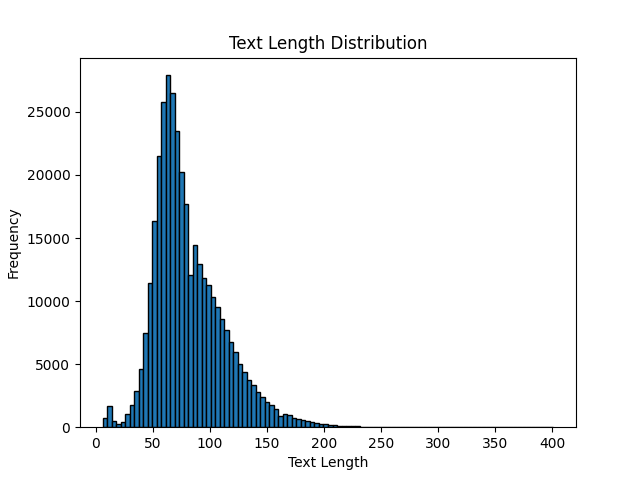

In [54]:
# Plotting the text length distribution
fig = plt.figure()
plt.hist(text_length, bins=100, edgecolor='black')  # Adjust the number of bins as per your preference
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')

In [57]:
import tiktoken

tokenizer = tiktoken.get_encoding('p50k_base')

token_length = []

for pair in prompt_completion_pairs:
    token_length.append(len(tokenizer.encode_ordinary(pair[0]+pair[1])))

print(f'mean: {np.mean(token_length)}, std: {np.std(token_length)}')
print(f'min: {np.min(token_length)}, max: {np.max(token_length)}')

mean: 110.25506703041054, std: 39.5447860225065
min: 13, max: 486


: 

Text(0.5, 1.0, 'Token Length Distribution')

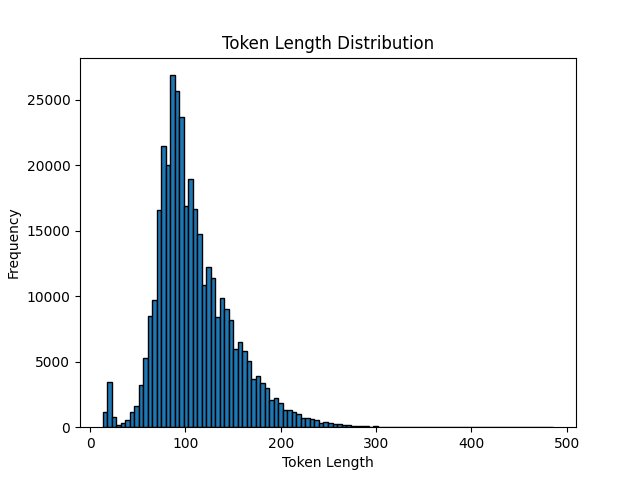

In [45]:
# Plotting the token length distribution
fig = plt.figure()
plt.hist(token_length, bins=100, edgecolor='black')  # Adjust the number of bins as per your preference
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')